In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve


conn = create_engine('postgresql://ubuntu@52.53.236.232:5432/collegesc')

%matplotlib inline

## Helper functions and other definitions

In [2]:
def query_data_def(conn, var_name):
    """
    var_name: name of column to query
    returns query from datadefinitions table showing definition of data
    """
    query = "SELECT * FROM datadefinitions WHERE developername='"+var_name+"';"
    return conn.execute(query).fetchall()

def check_highnull_columns(df, threshold=1000):
    """
    takes a dataframe and checks which columns
    have lower than threshold nulls
    returns partial dataframe with columns with low nulls
    """
    return df.loc[:, df.isnull().sum() < threshold]


def fit_and_show_metrics(model_dict, X_train, X_test, y_train, y_test):
    """
    Takes a dictionary of models, the training and test sets,
    and plots their ROC and Precision-Recall curves
    Then, returns the fitted models
    """
    for key in model_dict.keys():
        model_dict[key].fit(X_train, y_train)
        model_prob = model_dict[key].predict_proba(X_test)[:, 1]
    

        fpr, tpr, thresholds = roc_curve(y_test, model_prob)
        auc_score = integrate.trapz(tpr, x=fpr)
        
        prec, recall, thresholds = precision_recall_curve(y_test, model_prob)
        
        model_ll = log_loss(y_test, model_prob)
        
        print(key)
        print("AUC score: {}".format(auc_score))
        print("Log loss: {}".format(model_ll))
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(key)
        axes[0].plot(fpr, tpr)
        axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        
        axes[1].plot(prec, recall)
        axes[1].set_xlabel("Precision")
        axes[1].set_ylabel("Recall")
        
        plt.show()
        

    return model_dict


## Start with school table

In [3]:
school_all = """SELECT * FROM school;"""

In [4]:
school_df = pd.read_sql_query(school_all, conn)

In [5]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 43 columns):
index                                   7703 non-null int64
id                                      7703 non-null int64
location.lat                            7703 non-null float64
location.lon                            7703 non-null float64
accreditor                              6805 non-null object
alias                                   2178 non-null object
branches                                7703 non-null int64
carnegie_basic                          7282 non-null float64
carnegie_size_setting                   7282 non-null float64
carnegie_undergrad                      7282 non-null float64
city                                    7703 non-null object
degree_urbanization                     0 non-null object
degrees_awarded.highest                 7703 non-null int64
degrees_awarded.predominant             7703 non-null int64
degrees_awarded.predominant_recoded     0 

In [6]:
school_df.operating.value_counts()

1    6893
0     810
Name: operating, dtype: int64

### Remove uninteresting columns or columns with explicit or encoded nulls

In [7]:
school_columns = list(school_df.columns.values)

In [8]:
school_columns.remove('index')
school_columns.remove('alias')
school_columns.remove('degree_urbanization')
school_columns.remove('degrees_awarded.predominant_recoded')
school_columns.remove('faculty_salary')
school_columns.remove('ft_faculty_rate')
school_columns.remove('price_calculator_url')
school_columns.remove('url')
school_columns.remove('zip')
school_columns.remove('carnegie_basic')
school_columns.remove('carnegie_size_setting')
school_columns.remove('carnegie_undergrad')
school_columns.remove('online_only')
school_columns.remove('accreditor')
school_columns.remove('under_investigation')

## Get columns from student table next

In [9]:
student_all = "SELECT * FROM student;"

In [10]:
student_df = pd.read_sql_query(student_all, conn)

In [11]:
student_lownull_df = check_highnull_columns(student_df, threshold=2000)

In [12]:
student_lownull_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 39 columns):
index                                             7703 non-null int64
FAFSA_applications                                7204 non-null float64
avg_dependent_income.2014dollars                  6835 non-null float64
avg_independent_income.2014dollars                6835 non-null float64
demographics.age_entry                            7204 non-null float64
demographics.avg_family_income                    7204 non-null float64
demographics.avg_family_income_independents       6835 non-null float64
demographics.dependent                            6829 non-null float64
demographics.female_share                         6259 non-null float64
demographics.first_generation                     6534 non-null float64
demographics.married                              6495 non-null float64
demographics.median_family_income                 7204 non-null float64
demographics.men               

In [13]:
student_lownull_df['parents_education_level'].describe()

count      6568.000000
mean       4959.635201
std       12477.427315
min          11.000000
25%         320.000000
50%        1074.000000
75%        3380.000000
max      136770.000000
Name: parents_education_level, dtype: float64

In [14]:
student_lownull = list(student_lownull_df.columns.values)

In [15]:
student_lownull.remove('index')
student_lownull.remove('avg_dependent_income.2014dollars')
student_lownull.remove('demographics.avg_family_income')
student_lownull.remove('demographics.avg_family_income_independents')
student_lownull.remove('avg_independent_income.2014dollars')
student_lownull.remove('FAFSA_applications')
student_lownull.remove('family_income.dependent_students')
student_lownull.remove('family_income.independent_students')
student_lownull.remove('family_income.overall')
student_lownull.remove('valid_dependency_status')
student_lownull.remove('parents_education_level')
student_lownull.remove('id')
student_lownull.remove('students_with_pell_grant')
student_lownull

['demographics.age_entry',
 'demographics.dependent',
 'demographics.female_share',
 'demographics.first_generation',
 'demographics.married',
 'demographics.median_family_income',
 'demographics.men',
 'demographics.race_ethnicity.aian',
 'demographics.race_ethnicity.asian',
 'demographics.race_ethnicity.black',
 'demographics.race_ethnicity.hispanic',
 'demographics.race_ethnicity.nhpi',
 'demographics.race_ethnicity.non_resident_alien',
 'demographics.race_ethnicity.two_or_more',
 'demographics.race_ethnicity.unknown',
 'demographics.race_ethnicity.white',
 'demographics.women',
 'fafsa_sent.2_college_allyrs',
 'part_time_share',
 'share_25_older',
 'share_firstgeneration',
 'share_firstgeneration_parents.somecollege',
 'share_independent_students',
 'share_lowincome.0_30000',
 'share_middleincome.30001_48000',
 'size']

## Select only interesting features and add/recode features

In [16]:
operating_query = 'SELECT \n school."' + '",school."'.join(school_columns) + '",repayment."3_yr_default_rate"'
operating_query += ', aid."federal_loan_rate", aid."pell_grant_rate",student."'
operating_query += '",student."'.join(student_lownull)+'"'
operating_query += """                       
                    FROM 
                        school
                    JOIN repayment ON school.id=repayment.id
                    JOIN aid ON school.id=aid.id
                    JOIN student ON school.id=student.id;"""
operating_query

'SELECT \n school."id",school."location.lat",school."location.lon",school."branches",school."city",school."degrees_awarded.highest",school."degrees_awarded.predominant",school."institutional_characteristics.level",school."instructional_expenditure_per_fte",school."locale",school."main_campus",school."men_only",school."minority_serving.aanipi",school."minority_serving.annh",school."minority_serving.hispanic",school."minority_serving.historically_black",school."minority_serving.nant",school."minority_serving.predominantly_black",school."minority_serving.tribal",school."name",school."operating",school."ownership",school."region_id",school."religious_affiliation",school."state",school."state_fips",school."tuition_revenue_per_fte",school."women_only",repayment."3_yr_default_rate", aid."federal_loan_rate", aid."pell_grant_rate",student."demographics.age_entry",student."demographics.dependent",student."demographics.female_share",student."demographics.first_generation",student."demographics.ma

In [17]:
school_df = pd.read_sql_query(operating_query, conn)

In [18]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 57 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7270 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Check to make sure not too many nulls are associated with not operating

In [19]:
operating_df = school_df.loc[school_df.operating==1]
operating_df.isnull().sum().sum()/operating_df.size

0.071949422373575017

In [20]:
not_operating_df = school_df.loc[school_df.operating==0]
not_operating_df.isnull().sum().sum()/not_operating_df.size

0.097357591509638297

### Recode locale to 4 values instead of 12

In [21]:
locale_recode = school_df.locale.astype(str).values

In [22]:
locale_recode = [int(x[0]) if x[0] in ['1','2','3'] else 0 for x in locale_recode]

In [23]:
school_df['locale_recode'] = locale_recode

In [24]:
school_df['locale_recode'].value_counts()

1    3509
2    2291
0     986
3     917
Name: locale_recode, dtype: int64

### Recode religion to religious and non-religious

In [25]:
religion_recode = (np.nan_to_num(school_df.religious_affiliation.values) > 0).astype(int)

In [26]:
np.unique(religion_recode)

array([0, 1])

In [27]:
school_df['religion_recode'] = religion_recode

In [28]:
school_df.religion_recode.value_counts()

0    6793
1     910
Name: religion_recode, dtype: int64

### Recode gender-specific schools

In [29]:
school_df['gender_specific'] = np.nan_to_num((school_df.men_only + school_df.women_only).values)

In [30]:
school_df.gender_specific.value_counts()

0.0    7598
1.0     105
Name: gender_specific, dtype: int64

### Recode minority-serving schools

In [31]:
minority_specific = np.nan_to_num((school_df['minority_serving.aanipi'] +\
                        school_df['minority_serving.annh'] +\
                        school_df['minority_serving.hispanic'] +\
                        school_df['minority_serving.historically_black'] +\
                        school_df['minority_serving.nant'] +\
                        school_df['minority_serving.predominantly_black'] +\
                        school_df['minority_serving.tribal']).values)

In [32]:
minority_specific = (minority_specific > 0).astype(int)

In [33]:
school_df['minority_specific'] = minority_specific

### Recode for-profit vs. non-profit (private or public)

In [34]:
school_df['for_profit'] = (school_df.ownership == 3).astype(int)

In [35]:
school_df.for_profit.value_counts()

0    4000
1    3703
Name: for_profit, dtype: int64

### Impute continuous variables with mean

In [36]:
continuous_vars = ['instructional_expenditure_per_fte', 'tuition_revenue_per_fte', '3_yr_default_rate',
                  'federal_loan_rate', 'pell_grant_rate', 'demographics.age_entry', 
                  'demographics.dependent', 'demographics.female_share', 'demographics.married',
                  'demographics.median_family_income', 'demographics.race_ethnicity.aian',
                   'demographics.race_ethnicity.asian','demographics.race_ethnicity.black',
                   'demographics.race_ethnicity.hispanic','demographics.race_ethnicity.nhpi',
                   'demographics.race_ethnicity.non_resident_alien',
                   'demographics.race_ethnicity.two_or_more',
                   'demographics.race_ethnicity.unknown','demographics.race_ethnicity.white',
                   'fafsa_sent.2_college_allyrs', 'part_time_share','share_25_older',
                   'share_firstgeneration','share_firstgeneration_parents.somecollege',
                   'share_independent_students','share_lowincome.0_30000',
                   'share_middleincome.30001_48000','size']


In [37]:
for var in continuous_vars:
    school_df[var].fillna(school_df[var].mean(), inplace=True)
    

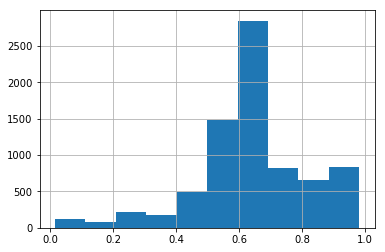

In [38]:
school_df['demographics.female_share'].hist()

In [39]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 62 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
locale                                            7282 non-null float64
main_campus                                       7703 non-null int64
men_only                                          7282 non-null float64
minority_serving.aanipi                   

### Pare down to relevant columns

In [40]:
cleaned_school_df = school_df.drop(['locale', 'men_only',
                                    'minority_serving.aanipi', 'minority_serving.annh',
                                    'minority_serving.hispanic', 'minority_serving.historically_black',
                                    'minority_serving.nant', 'minority_serving.predominantly_black',
                                    'minority_serving.tribal', 'religious_affiliation', 'state', 
                                    'state_fips','women_only', 'demographics.men',
                                    'demographics.women', 'demographics.first_generation'], axis = 1)

In [41]:
cleaned_school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7703 entries, 0 to 7702
Data columns (total 46 columns):
id                                                7703 non-null int64
location.lat                                      7703 non-null float64
location.lon                                      7703 non-null float64
branches                                          7703 non-null int64
city                                              7703 non-null object
degrees_awarded.highest                           7703 non-null int64
degrees_awarded.predominant                       7703 non-null int64
institutional_characteristics.level               7703 non-null int64
instructional_expenditure_per_fte                 7703 non-null float64
main_campus                                       7703 non-null int64
name                                              7703 non-null object
operating                                         7703 non-null int64
ownership                                    

In [42]:
cleaned_school_df['not_operating'] =  1 - cleaned_school_df.operating

In [43]:
cleaned_school_df.not_operating.value_counts()

0    6893
1     810
Name: not_operating, dtype: int64

## Select columns for classification


In [44]:
X = cleaned_school_df.drop(['id', 'city', 'name',
                            'ownership', 'region_id',
                            'operating', 'not_operating'], axis = 1)
y = cleaned_school_df.not_operating

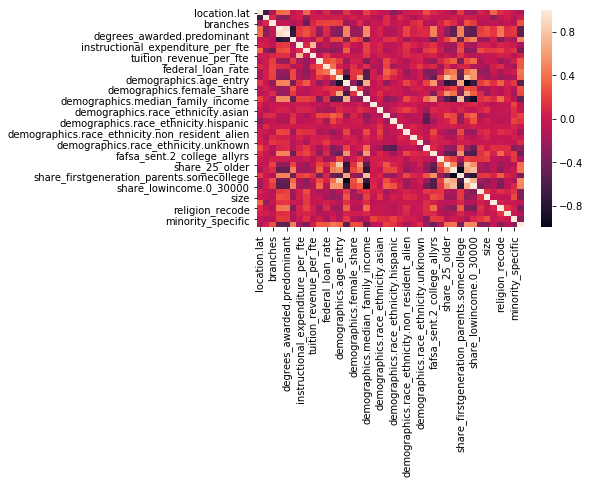

In [45]:
sns.heatmap(X.corr())

### Split data, run several models

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [47]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



In [48]:
models = dict()
models['Logistic L1'] = LogisticRegression(penalty='l1', C=0.5)
models['Logistic L2'] = LogisticRegression(C=0.5)
models['KNN'] = KNeighborsClassifier(n_neighbors=6)
models['Tree'] = DecisionTreeClassifier()
models['RandomForest'] = RandomForestClassifier(n_estimators=1000)
models['GradBoostTrees'] = GradientBoostingClassifier()

Logistic L1
AUC score: 0.8137070592974668
Log loss: 0.27414164189334783


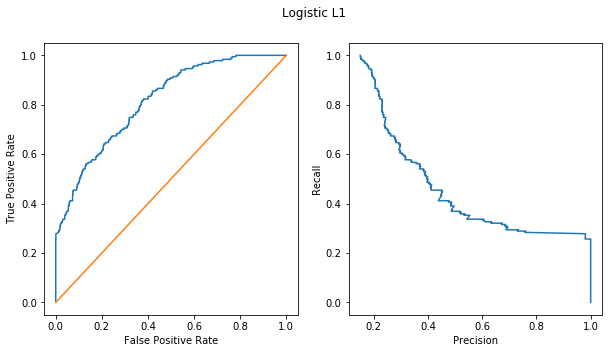

Logistic L2
AUC score: 0.7947772099305682
Log loss: 0.2840603453341495


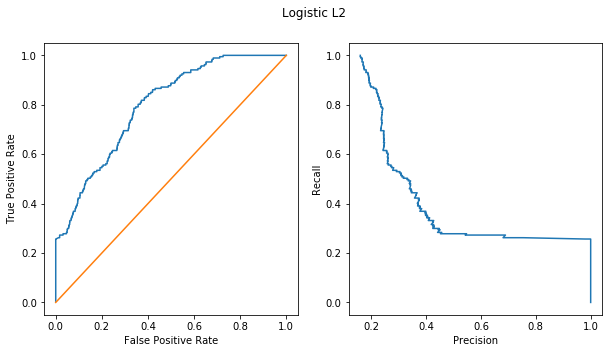

KNN
AUC score: 0.7476994289054415
Log loss: 1.5695637681502665


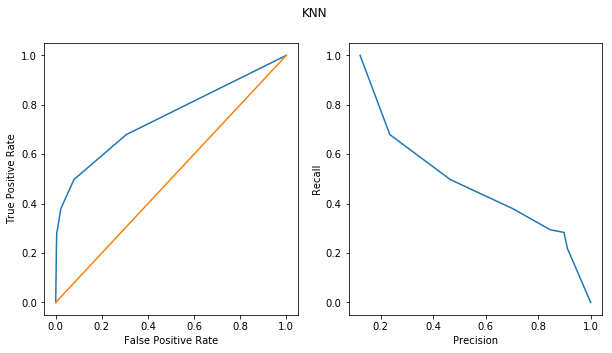

Tree
AUC score: 0.722594570257269
Log loss: 3.9248275289645673


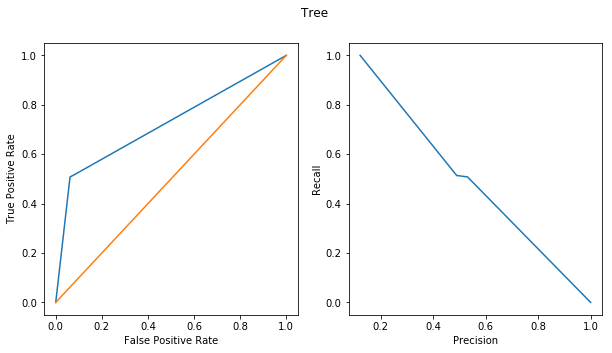

RandomForest
AUC score: 0.8956587334813072
Log loss: 0.2508814701650014


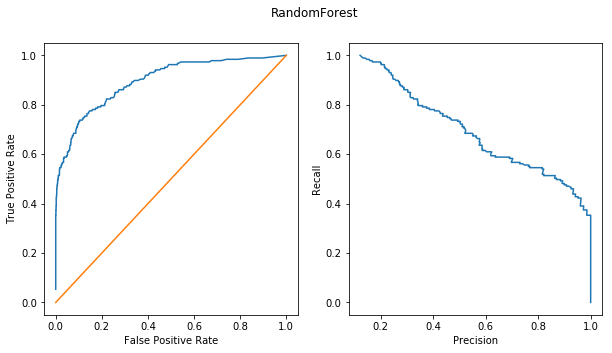

GradBoostTrees
AUC score: 0.8754749247624388
Log loss: 0.23402038639154454


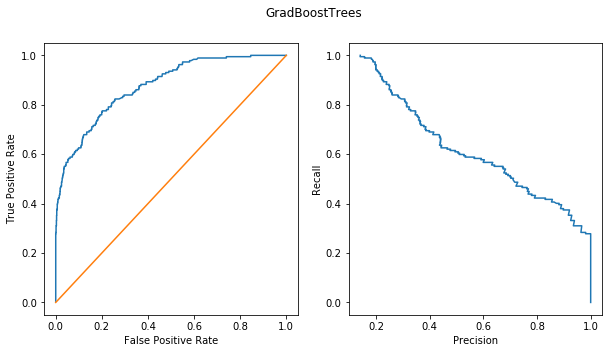

In [49]:
fit_models = fit_and_show_metrics(models, X_train, X_test, y_train, y_test)

### Check features in best models

In [50]:
lasso_log_coef = sorted(list(zip(X.columns, fit_models['Logistic L1'].coef_[0])), key = lambda x: x[1], reverse=True)
lasso_log_coef

[('demographics.race_ethnicity.unknown', 2.9433685081057468),
 ('share_25_older', 1.4712620458273871),
 ('3_yr_default_rate', 1.4351364468170975),
 ('pell_grant_rate', 0.65922435928572198),
 ('fafsa_sent.2_college_allyrs', 0.5115157247101112),
 ('for_profit', 0.40092794872086351),
 ('demographics.race_ethnicity.two_or_more', 0.34580378531526534),
 ('institutional_characteristics.level', 0.24413794980984632),
 ('demographics.female_share', 0.14474188731014886),
 ('religion_recode', 0.083550068885728843),
 ('federal_loan_rate', 0.075182810422856419),
 ('branches', 0.02995339820844416),
 ('location.lat', 0.0023000951875900284),
 ('location.lon', 0.0014443644687420916),
 ('tuition_revenue_per_fte', 2.1485776751923515e-05),
 ('instructional_expenditure_per_fte', 1.6544348412123984e-06),
 ('demographics.dependent', 0.0),
 ('demographics.married', 0.0),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.0),
 ('demographics.race_ethnicity.black', 0.0),
 ('demo

In [51]:
rf_feat_imp = sorted(list(zip(X.columns, fit_models['RandomForest'].feature_importances_)), key = lambda x: x[1], reverse=True)
rf_feat_imp

[('branches', 0.12314525374815158),
 ('demographics.female_share', 0.051354208985450109),
 ('demographics.median_family_income', 0.045163777187076704),
 ('3_yr_default_rate', 0.040740971791903231),
 ('share_lowincome.0_30000', 0.03520790662958162),
 ('tuition_revenue_per_fte', 0.034954032608995059),
 ('share_independent_students', 0.032985689280780654),
 ('share_firstgeneration', 0.032528226715061309),
 ('pell_grant_rate', 0.032359857609766597),
 ('size', 0.031826094975453821),
 ('instructional_expenditure_per_fte', 0.031652102350106334),
 ('location.lat', 0.031019956069074348),
 ('demographics.race_ethnicity.unknown', 0.030987398663179191),
 ('demographics.dependent', 0.030879887617233193),
 ('share_firstgeneration_parents.somecollege', 0.029401023581206571),
 ('share_middleincome.30001_48000', 0.028351281487552692),
 ('location.lon', 0.02806664986533863),
 ('demographics.married', 0.026403775563959606),
 ('fafsa_sent.2_college_allyrs', 0.026020721809102337),
 ('federal_loan_rate', 0.

In [129]:
sorted(list(zip(X.columns, fit_models['GradBoostTrees'].feature_importances_)), key = lambda x: x[1], reverse=True)

[('branches', 0.16314082175212627),
 ('fafsa_sent.2_college_allyrs', 0.065893758919356449),
 ('tuition_revenue_per_fte', 0.052909594498387176),
 ('demographics.median_family_income', 0.05083113414006827),
 ('demographics.race_ethnicity.unknown', 0.049883605875017036),
 ('share_middleincome.30001_48000', 0.048737123230701417),
 ('3_yr_default_rate', 0.046696817884079832),
 ('demographics.female_share', 0.042574533100276174),
 ('size', 0.041711041123640956),
 ('instructional_expenditure_per_fte', 0.035932139119859541),
 ('location.lat', 0.032775695718364216),
 ('share_lowincome.0_30000', 0.032489892728760295),
 ('share_firstgeneration_parents.somecollege', 0.031612236367175854),
 ('demographics.race_ethnicity.two_or_more', 0.02400508901097155),
 ('pell_grant_rate', 0.02374132384226578),
 ('demographics.race_ethnicity.white', 0.020144130117947853),
 ('demographics.race_ethnicity.hispanic', 0.019617336370737402),
 ('demographics.race_ethnicity.black', 0.01954704927887433),
 ('for_profit', 

Both random forest and gradient boosted trees latched onto "branches" since 144 of the schools that closed were the branches of ITT Tech. Try running again without ITT Tech.

In [52]:
cleaned_school_df.loc[cleaned_school_df.branches > 60, ['name', 'not_operating', 'branches']].head(10)

,name,not_operating,branches
31,ITT Technical Institute-Albany,1,142
32,ITT Technical Institute-Liverpool,1,142
45,ITT Technical Institute-Saint Rose,1,142
138,Strayer University-Cedar Hill,0,80
139,Strayer University-North Dallas,0,80
140,Strayer University-San Antonio,0,80
141,Strayer University-Stafford,0,80
348,ITT Technical Institute-Pensacola,1,142
349,ITT Technical Institute-San Antonio East,1,142
556,ITT Technical Institute-Marlton,1,142


In [62]:
X = cleaned_school_df.loc[cleaned_school_df.branches != 142].drop(['id', 'city', 'name',
                                                                    'ownership', 'region_id',
                                                                    'operating', 'not_operating'], axis=1)
y = cleaned_school_df.not_operating.loc[cleaned_school_df.branches != 142]

In [63]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7561 entries, 0 to 7702
Data columns (total 40 columns):
location.lat                                      7561 non-null float64
location.lon                                      7561 non-null float64
branches                                          7561 non-null int64
degrees_awarded.highest                           7561 non-null int64
degrees_awarded.predominant                       7561 non-null int64
institutional_characteristics.level               7561 non-null int64
instructional_expenditure_per_fte                 7561 non-null float64
main_campus                                       7561 non-null int64
tuition_revenue_per_fte                           7561 non-null float64
3_yr_default_rate                                 7561 non-null float64
federal_loan_rate                                 7561 non-null float64
pell_grant_rate                                   7561 non-null float64
demographics.age_entry                 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [65]:
models_noITT = dict()
models_noITT['Logistic L1'] = LogisticRegression(penalty='l1', C = 0.5)
models_noITT['Logistic L2'] = LogisticRegression(C=0.5)
models_noITT['KNN'] = KNeighborsClassifier(n_neighbors=6)
models_noITT['Tree'] = DecisionTreeClassifier()
models_noITT['RandomForest'] = RandomForestClassifier(n_estimators=1000)
models_noITT['GradBoostTrees'] = GradientBoostingClassifier()

Logistic L1
AUC score: 0.8286009703332538
Log loss: 0.2171220595234381


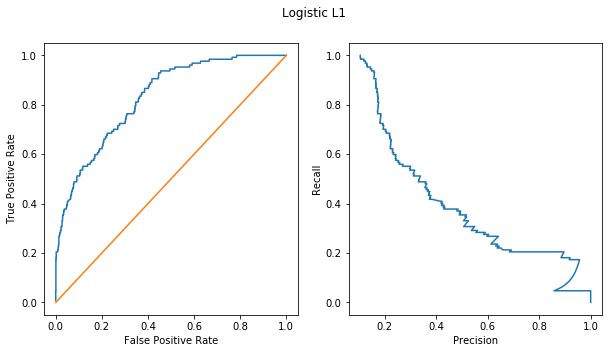

Logistic L2
AUC score: 0.7960794673393099
Log loss: 0.23179213412019778


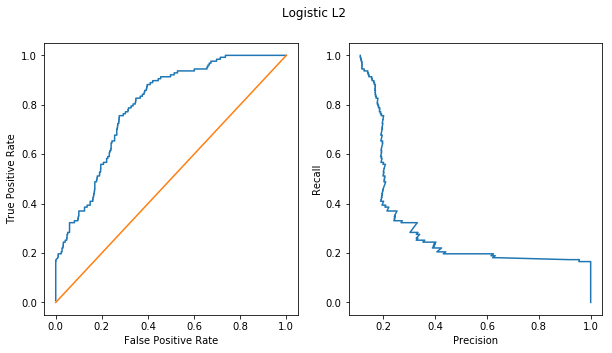

KNN
AUC score: 0.7361835452386634
Log loss: 1.0496367830982156


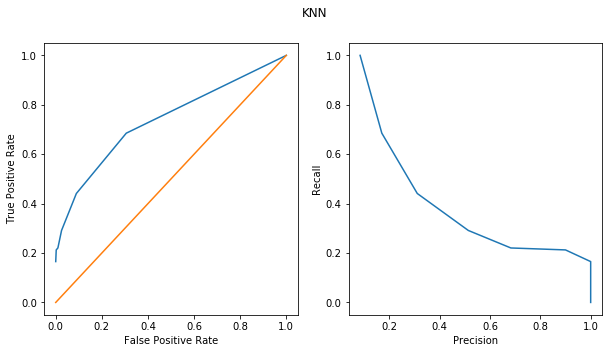

Tree
AUC score: 0.6713734646805514
Log loss: 3.7490524118269195


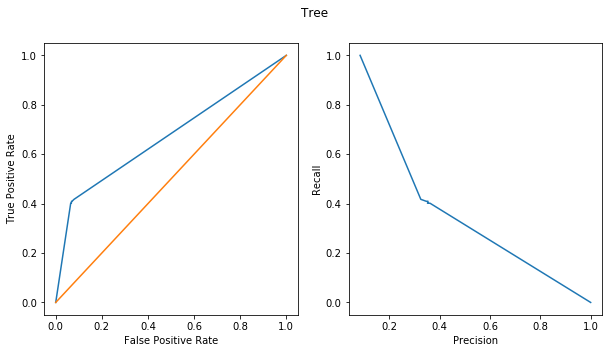

RandomForest
AUC score: 0.887548147390667
Log loss: 0.17780296039031146


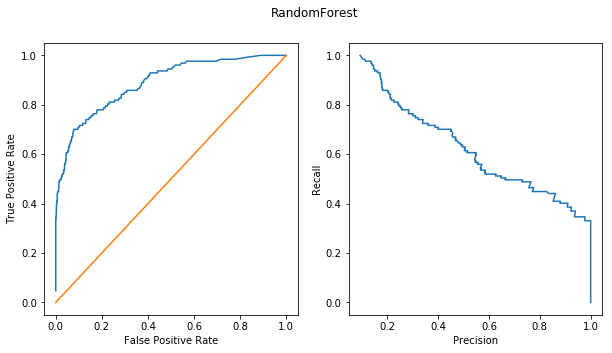

GradBoostTrees
AUC score: 0.8757314426605766
Log loss: 0.18659145489916887


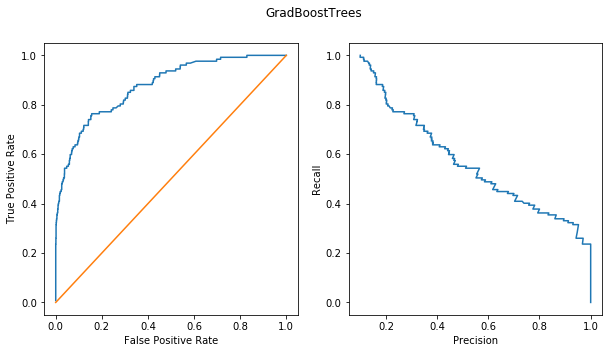

In [66]:
fit_models_noITT = fit_and_show_metrics(models_noITT, X_train, X_test, y_train, y_test)

In [70]:
log_coef_noITT = sorted(list(zip(X.columns, fit_models_noITT['Logistic L1'].coef_[0])), key = lambda x: x[1], reverse=True)
log_coef_noITT

[('demographics.race_ethnicity.unknown', 3.7423017080689203),
 ('demographics.race_ethnicity.two_or_more', 2.4166128995625273),
 ('fafsa_sent.2_college_allyrs', 1.0691041756212725),
 ('3_yr_default_rate', 0.87970605869423713),
 ('pell_grant_rate', 0.73444027882059182),
 ('share_25_older', 0.56859201474832233),
 ('demographics.female_share', 0.53651335074306028),
 ('for_profit', 0.4551098556367294),
 ('religion_recode', 0.043945972588049574),
 ('location.lat', 0.0067089460476628246),
 ('location.lon', 0.0042147335474449366),
 ('branches', 0.0035647855875201896),
 ('tuition_revenue_per_fte', 1.8887396213504189e-05),
 ('instructional_expenditure_per_fte', 8.275201838072734e-06),
 ('institutional_characteristics.level', 0.0),
 ('federal_loan_rate', 0.0),
 ('demographics.dependent', 0.0),
 ('demographics.married', 0.0),
 ('demographics.race_ethnicity.aian', 0.0),
 ('demographics.race_ethnicity.asian', 0.0),
 ('demographics.race_ethnicity.black', 0.0),
 ('demographics.race_ethnicity.nhpi', 0

In [71]:
rf_feat_imp_noITT = sorted(list(zip(X.columns, fit_models_noITT['RandomForest'].feature_importances_)), key = lambda x: x[1], reverse=True)
rf_feat_imp_noITT

[('branches', 0.058219262508411383),
 ('demographics.female_share', 0.046205807518965081),
 ('demographics.median_family_income', 0.045709540998147183),
 ('demographics.race_ethnicity.unknown', 0.042795938183236827),
 ('size', 0.039789502912679769),
 ('instructional_expenditure_per_fte', 0.039325406469197313),
 ('tuition_revenue_per_fte', 0.03735617405662655),
 ('3_yr_default_rate', 0.037325615233244687),
 ('location.lat', 0.037016470463220652),
 ('location.lon', 0.033500406371431382),
 ('share_independent_students', 0.033078323315900458),
 ('share_middleincome.30001_48000', 0.032869762465750414),
 ('share_lowincome.0_30000', 0.032564615566037507),
 ('pell_grant_rate', 0.03187673057951098),
 ('demographics.dependent', 0.031466352030304394),
 ('demographics.married', 0.029619393360826016),
 ('fafsa_sent.2_college_allyrs', 0.028906218317147282),
 ('share_firstgeneration', 0.025476971772197696),
 ('demographics.race_ethnicity.two_or_more', 0.025352677766946413),
 ('demographics.race_ethni

#### Removing ITT Tech reduces the importance of branches

### Plot coefficients for logistic regression and feature importances for RandomForest

In [72]:
lasso_log_coef_names = [x[0] for x in log_coef_noITT if abs(x[1]) > 0.1]
lasso_log_coefs_imp = [x[1] for x in log_coef_noITT if abs(x[1]) > 0.1]

In [73]:
rf_feat_imp_names = [x[0] for x in rf_feat_imp_noITT if x[1] > 0.03]
rf_feat_imp_values = [x[1] for x in rf_feat_imp_noITT if x[1] > 0.03]

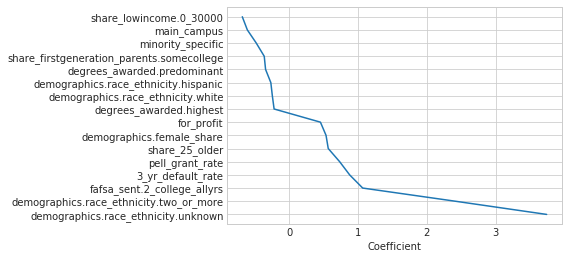

In [74]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1)

ax.plot(lasso_log_coefs_imp, range(len(lasso_log_coef_names)))
plt.yticks(range(len(lasso_log_coef_names)), lasso_log_coef_names)
ax.set_xlabel("Coefficient")

fig.savefig('coefficients_noITT_lasso.png', fmt='png', dpi=600, bbox_inches='tight')

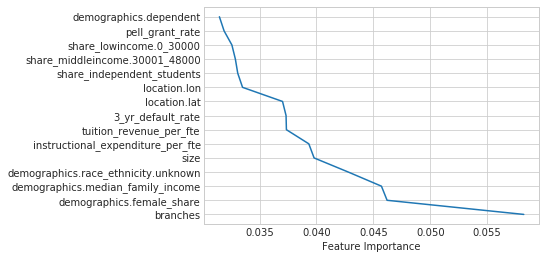

In [75]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1)

ax.plot(rf_feat_imp_values, range(len(rf_feat_imp_names)))
plt.yticks(range(len(rf_feat_imp_names)), rf_feat_imp_names)
ax.set_xlabel("Feature Importance")

fig.savefig('featimp_rf.png', fmt='png', dpi=600, bbox_inches='tight')

### Combine predictions of Logistic Regression and Random Forest without ITT Tech

Both models seem to be picking up on different features, so their geometric mean could work better.

In [79]:
probRF = fit_models_noITT['RandomForest'].predict_proba(X_test)[:, 1]
probLog = fit_models_noITT['Logistic L1'].predict_proba(X_test)[:, 1]

In [80]:
prob_combined = (probRF * probLog)**0.5

Ensemble of Random Forest and Logistic Regression
AUC score: 0.8872498892183933
Log loss: 0.1873527010924376


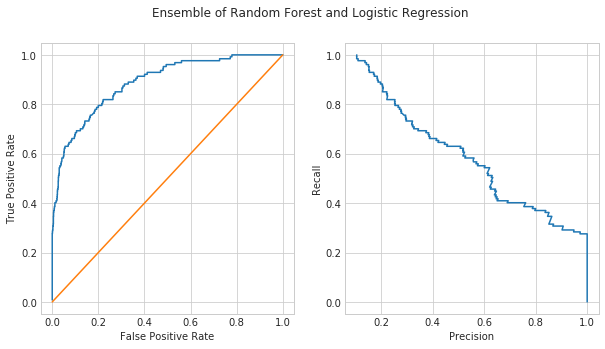

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, prob_combined)
auc_score = integrate.trapz(tpr, x=fpr)

prec, recall, thresholds = precision_recall_curve(y_test, prob_combined)

model_ll = log_loss(y_test, prob_combined)
key = "Ensemble of Random Forest and Logistic Regression"
print(key)
print("AUC score: {}".format(auc_score))
print("Log loss: {}".format(model_ll))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(key)
axes[0].plot(fpr, tpr)
axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].plot(prec, recall)
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")

plt.show()

### Sanity check: Look only main campuses 

In [82]:
campus_filter = (cleaned_school_df.branches >= 1) &\
                (cleaned_school_df.main_campus == 1) |\
                (cleaned_school_df.branches == 0)
main_campus_df = cleaned_school_df.loc[campus_filter]

In [83]:
main_campus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5685 entries, 1 to 7702
Data columns (total 47 columns):
id                                                5685 non-null int64
location.lat                                      5685 non-null float64
location.lon                                      5685 non-null float64
branches                                          5685 non-null int64
city                                              5685 non-null object
degrees_awarded.highest                           5685 non-null int64
degrees_awarded.predominant                       5685 non-null int64
institutional_characteristics.level               5685 non-null int64
instructional_expenditure_per_fte                 5685 non-null float64
main_campus                                       5685 non-null int64
name                                              5685 non-null object
operating                                         5685 non-null int64
ownership                                    

In [84]:
X = main_campus_df.drop(['id', 'city', 'name', 'ownership', 'region_id', 'operating', 'not_operating'], axis = 1)
y = main_campus_df.not_operating

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [86]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.05255057167985928, 0.05364995602462621)

In [87]:
models_mc = dict()
models_mc['Logistic L1'] = LogisticRegression(penalty='l1', C = 0.5)
models_mc['RandomForest'] = RandomForestClassifier(n_estimators=1000)

Logistic L1
AUC score: 0.849427143640685
Log loss: 0.16332751599179254


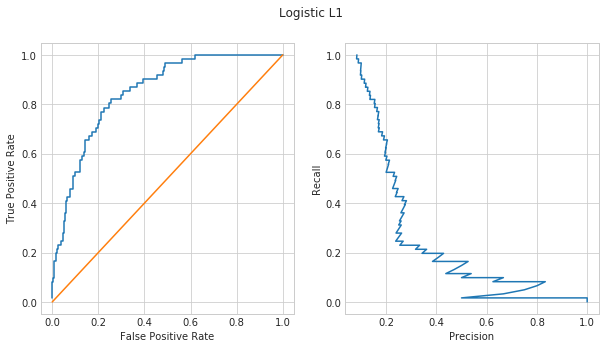

RandomForest
AUC score: 0.8851697239319886
Log loss: 0.15224286826591849


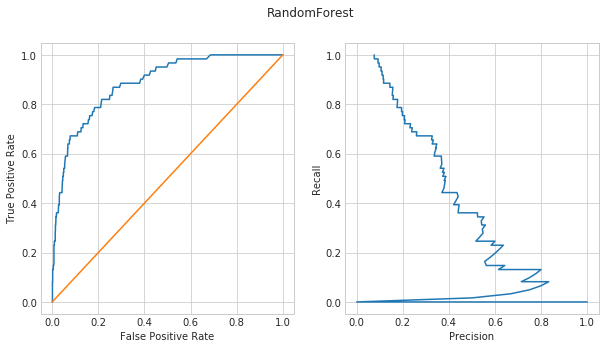

In [88]:
fit_models_mc = fit_and_show_metrics(models_mc, X_train, X_test, y_train, y_test)

In [89]:
probRF_mc = fit_models_mc['RandomForest'].predict_proba(X_test)[:, 1]
probLog_mc = fit_models_mc['Logistic L1'].predict_proba(X_test)[:, 1]

In [90]:
prob_combined_mc = (probRF_mc * probLog_mc)**0.5

Ensemble of Random Forest and Logistic Regression
AUC score: 0.8881254189773904
Log loss: 0.15336277957363034


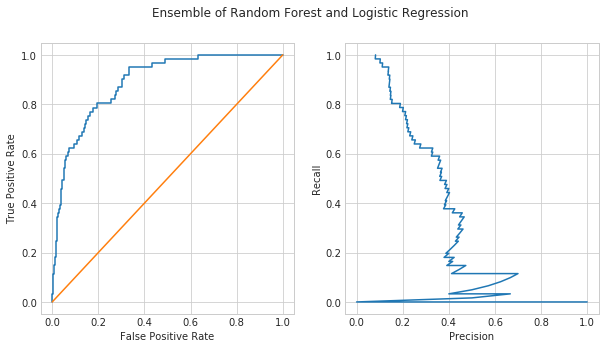

In [91]:
fpr, tpr, thresholds = roc_curve(y_test, prob_combined_mc)
auc_score = integrate.trapz(tpr, x=fpr)

prec, recall, thresholds = precision_recall_curve(y_test, prob_combined_mc)

model_ll = log_loss(y_test, prob_combined_mc)
key = "Ensemble of Random Forest and Logistic Regression"
print(key)
print("AUC score: {}".format(auc_score))
print("Log loss: {}".format(model_ll))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(key)
axes[0].plot(fpr, tpr)
axes[0].plot(np.linspace(0,1,3),np.linspace(0,1,3))
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].plot(prec, recall)
axes[1].set_xlabel("Precision")
axes[1].set_ylabel("Recall")

plt.show()

### Use ML insights to better understand random forest model without ITT Tech

In [98]:
import ml_insights as mli

In [92]:
X = cleaned_school_df.loc[cleaned_school_df.branches != 142].drop(['id', 'city', 'name',
                                                                    'ownership', 'region_id',
                                                                    'operating', 'not_operating'], axis=1)
y = cleaned_school_df.not_operating.loc[cleaned_school_df.branches != 142]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [95]:
smaller_forest = RandomForestClassifier(n_estimators=100)

In [96]:
smaller_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [99]:
mxr_rf = mli.ModelXRay(smaller_forest,X_test)

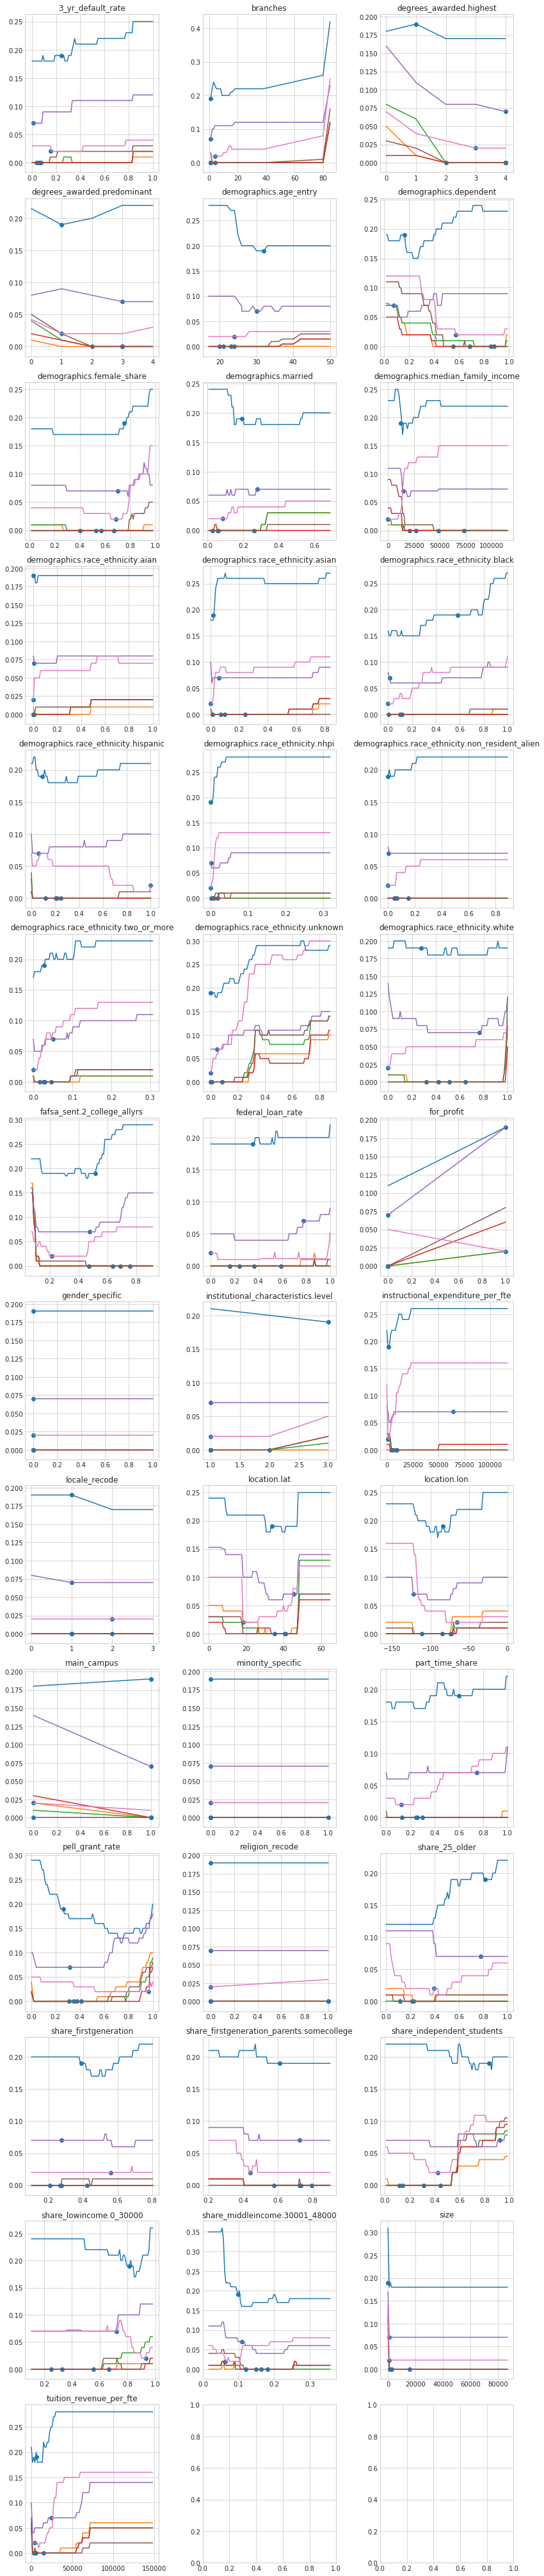

In [100]:
indices = mxr_rf.feature_dependence_plots(num_pts=7)

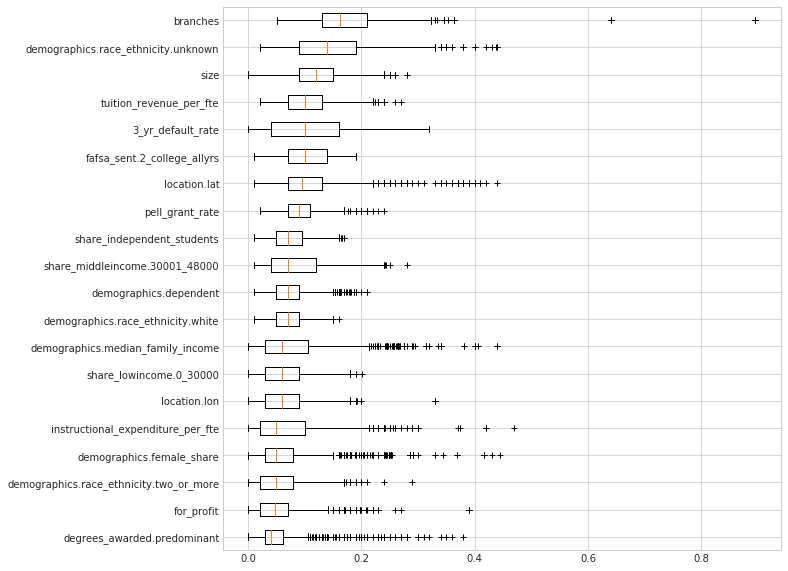

In [102]:
mxr_rf.feature_effect_summary()

In [103]:
indices

array([ 270,  786, 1093, 1127, 1455,  554, 1490])

In [111]:
diff_path_obj = mxr_rf.explain_prediction_difference(270, 1490, tol=.05) #Puerto Rican school

Your initial point has a target value of 0.19
Your final point has a target value of 0.02
Changing demographics.age_entry from 32.0 to 24.0
		changes your target by 0.08 to 0.27
----------
Changing share_25_older from 0.8148 to 0.3962
		changes your target by -0.08 to 0.19
----------
Changing size from 108.0 to 631.0
		changes your target by -0.04 to 0.15
----------
Changing demographics.married from 0.1921 to 0.0845
		changes your target by 0.06 to 0.21
----------
Changing share_middleincome.30001_48000 from 0.0993 to 0.0627
		changes your target by 0.05 to 0.26
----------
Changing demographics.race_ethnicity.black from 0.5833 to 0.0
		changes your target by -0.04 to 0.22
----------
Changing branches from 1.0 to 4.0
		changes your target by 0.06 to 0.28
----------
Changing 3_yr_default_rate from 0.242 to 0.156
		changes your target by -0.05 to 0.23
----------
Changing share_firstgeneration_parents.somecollege from 0.6087 to 0.4417
		changes your target by 0.03 to 0.26
----------
Chang

In [109]:
diff_path_obj = mxr_rf.explain_prediction_difference(270, 1455, tol=.05)

Your initial point has a target value of 0.19
Your final point has a target value of 0.07
Changing for_profit from 1.0 to 0.0
		changes your target by -0.08 to 0.11
----------
Changing instructional_expenditure_per_fte from 1455.0 to 64019.0
		changes your target by 0.07 to 0.18
----------
Changing federal_loan_rate from 0.3538 to 0.7782
		changes your target by 0.06 to 0.24
----------
Changing tuition_revenue_per_fte from 6539.0 to 24021.0
		changes your target by 0.06 to 0.3
----------
Changing 3_yr_default_rate from 0.242 to 0.011
		changes your target by -0.07 to 0.23
----------
Changing share_middleincome.30001_48000 from 0.0993 to 0.1089
		changes your target by -0.06 to 0.17
----------
Changing size from 108.0 to 832.0
		changes your target by -0.03 to 0.14
----------
Changing degrees_awarded.highest from 1.0 to 4.0
		changes your target by -0.04 to 0.1
----------
Changing demographics.median_family_income from 12148.0 to 14353.0
		changes your target by 0.03 to 0.13
----------


(array([  1.07700000e+03,   2.50000000e+02,   8.70000000e+01,
          4.40000000e+01,   1.20000000e+01,   6.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   7.00000000e+00,
          2.70000000e+01]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

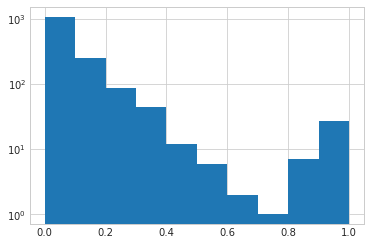

In [107]:
plt.hist(probRF, log=True)

In [113]:
(probRF < 0.05).sum()/len(probRF)

0.52280237937871776

### Predict risk for each school using RF model without ITT

In [151]:
X = cleaned_school_df.drop(['id', 'city', 'name',
                            'ownership', 'region_id',
                            'operating', 'not_operating'], axis = 1)
y = cleaned_school_df.not_operating

In [172]:
risk_closing = fit_models_noITT['RandomForest'].predict_proba(X)[:, 1]

(array([ 6387.,   433.,   101.,   176.,    27.,    15.,   179.,   189.,
           66.,   130.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

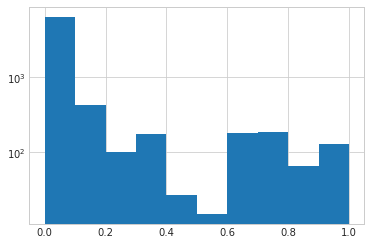

In [173]:
plt.hist(risk_closing, log=True)

In [210]:
school_risk_df = cleaned_school_df.copy()

In [211]:
school_risk_df['risk'] = risk_closing

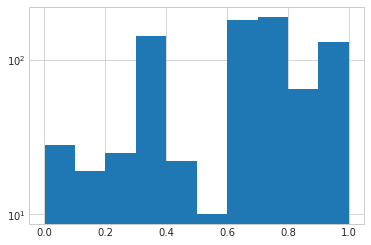

In [176]:
school_risk_df.loc[(school_risk_df.not_operating == 1), 'risk'].hist(log=True)

In [177]:
school_risk_df.head()

,id,location.lat,location.lon,branches,city,degrees_awarded.highest,degrees_awarded.predominant,institutional_characteristics.level,instructional_expenditure_per_fte,main_campus,...,share_lowincome.0_30000,share_middleincome.30001_48000,size,locale_recode,religion_recode,gender_specific,minority_specific,for_profit,not_operating,risk
0,121983,37.781238,-122.267523,28,Alameda,4,3,1,6663.0,0,...,0.719943,0.126186,168.000000,2,0,0.0,0,1,0,0.074000
1,120838,34.060700,-118.299841,1,Los Angeles,4,3,1,3404.0,1,...,0.627133,0.138686,14.000000,1,0,0.0,0,0,0,0.028000
2,434973,39.189991,-76.815804,38,Columbia,4,3,1,4688.0,0,...,0.734078,0.136853,479.000000,1,0,0.0,0,1,0,0.026045
3,436012,40.708670,-73.627681,2,Hempstead,1,1,3,2544.0,1,...,0.927419,0.138686,711.000000,2,0,0.0,0,0,1,0.673000
4,436021,42.986115,-87.870663,1,Milwaukee,0,0,1,3745.0,1,...,0.627133,0.138686,2381.592858,2,0,0.0,0,0,0,0.132000


In [212]:
school_risk_df['low_risk'] = (school_risk_df.risk < 0.1).astype(int)
school_risk_df['moderate_risk'] = ((school_risk_df.risk > 0.1) & (school_risk_df.risk < 0.3)).astype(int)
school_risk_df['high_risk'] = (school_risk_df.risk > 0.3).astype(int)

In [213]:
school_risk_df.to_csv('school_risk.csv', index=False)

In [202]:
school_risk_df.loc[(school_risk_df.risk < 0.1) & (school_risk_df.not_operating == 1), ['name', 'risk', 'for_profit', 'branches', 'city']]

{'high_risk': 'high risk'},name,risk,for_profit,branches,city
378,DeVry University-Michigan,0.062000,1,25,Southfield
760,Velvet Touch Academy of Cosmetology,0.056000,1,1,Nampa
885,Salinas Beauty College Inc,0.058000,1,1,Salinas
1042,Strayer University-Columbus,0.059727,1,80,Columbus
1113,Park Avenue School of Cosmetology,0.094200,1,1,Park Rapids
1169,Strayer University-Louisiana,0.047387,1,80,Metairie
1203,Preferred College of Nursing-Los Angeles,0.055000,1,1,Los Angeles
1262,Strayer University-Coral Springs Campus,0.059727,1,80,Coral Springs
1273,Rasmussen College-Bismarck,0.073308,1,23,Bismarck
1280,Strayer University-King of Prussia Campus,0.059727,1,80,King of Prussia


In [219]:
pared_risk_df = school_risk_df.loc[school_risk_df.not_operating==0, ['name', 'risk', 'low_risk', 'moderate_risk', 'high_risk', 'location.lat', 'location.lon']]

In [220]:
pared_risk_df.head()

,name,risk,low_risk,moderate_risk,high_risk,location.lat,location.lon
0,Argosy University-San Francisco Bay Area,0.074000,1,0,0,37.781238,-122.267523
1,Pacific States University,0.028000,1,0,0,34.060700,-118.299841
2,University of Phoenix-Maryland,0.026045,1,0,0,39.189991,-76.815804
4,Montessori Institute of Milwaukee,0.132000,0,1,0,42.986115,-87.870663
5,Hair Academy II,0.139000,0,1,0,38.839695,-76.948468


In [221]:
pared_risk_df.to_csv('pared_risk.csv', index=False)

In [223]:
pared_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6893 entries, 0 to 7702
Data columns (total 7 columns):
name             6893 non-null object
risk             6893 non-null float64
low_risk         6893 non-null int64
moderate_risk    6893 non-null int64
high_risk        6893 non-null int64
location.lat     6893 non-null float64
location.lon     6893 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 430.8+ KB


### Filter out Puerto Rico

In [243]:
onlyrisky_df = pared_risk_df.loc[(pared_risk_df.risk > 0.1) & (pared_risk_df['location.lat'] > 18.5)]

In [248]:
onlyrisky_df.high_risk.sum()

28

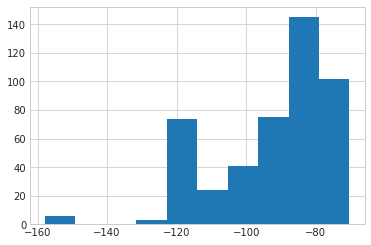

In [244]:
onlyrisky_df['location.lon'].hist()

In [245]:
onlyrisky_df.to_csv('highrisk.csv', index=False)